# Redes Bayesianas

Adaptado de Russell & Norvig (2016), caps. 13 y 14.

### Objetivo

En este notebook estudiaremos una herramienta muy útil para representar situaciones de incertidumbre, como las que aparecen, por ejemplo, en el mundo del Wumpus, aunque el rango de aplicaciones es muy amplio. Esta herramienta se llama las **redes bayesianas** y está basada, como su nombre lo indica, en la regla de Bayes, pero también en otras nociones fundamentales de la teoría de las probabilidades, como la independencia y la independencia condicional.

### Secciones

1. Implementación de la estructura de una red bayesiana.
* Implementación de las funciones de probabilidad.
* Inferencia probabilística y consultas basadas en evidencia.

### Estructura de una red bayesiana

Una **red bayesiana** está basada en un grafo dirigido, en donde cada vértice está etiquetado con una tabla de probabilidad condicional en función de su ascendencia. Para la implementación aquí realizada, usaremos el paquete igraph (correr en el terminal ``pip install python-igraph`` si aún no tiene instalado igraph). 

In [3]:
import igraph as ig
import itertools
import numpy as np

El siguiente código crea una clase llamada `red_bayesiana`, la cual tiene 2 atributos y 7 métodos:

**Atributos:**

1. `.red`: Objeto igraph en donde cada vértice tiene los atributos `nombre`, `valores`, `padres`, `probabilidades`.
* `.evidencia`: Diccionario de la forma `{variable:valor}`.

**Métodos:**

1. `.__init__()`: Inicializa el grafo subyacente a la red.
* `.crear_nodo()`: Crea un nuevo vértice y lo adiciona al grafo subyacente.
* `.crear_dependencia()`: Crea una arista dirigida, en el grafo subyacente, desde el nodo madre al nodo hijo. Representa la dependencia probabilística entre variables.
* `.asignar_probabilidades_m()`: Método para introducir la tabla de probabilidades de un nodo de manera manual. Se considera el número de `padres` que tiene el nodo en el grafo subyacente.
* `.asignar_probabilidades()`: Método para introducir la tabla de probabilidades con base en un diccionario de la forma `{(valores_variables_padres):[probabilidades_valores_nodo]}`.
* `.ver_nodo()`: Muestra la tabla de probabilidades del nodo.
* `.ver_red()`: Muestra el grafo subyacente de la red.

In [4]:
class red_bayesiana:
    '''
    Clase para generar una red bayesiana.
    Requiere import igraph as ig
    '''
    def __init__(self):
        red = ig.Graph(directed=True)
        red.vs['nombre'] = []
        red.vs['valores'] = []
        red.vs['padres'] = []
        red.vs['probabilidades'] = []
        self.red = red
        self.evidencia = {}
        
    def crear_nodo(self, nombre, valores):
        '''
        Crea un nuevo vértice y lo adiciona al grafo subyacente.
        Input: nombre, que es el nombre del nodo.
               valores, que es una lista de valores que puede tomar la variable.
        '''
        self.red.add_vertices(1)
        self.red.vs[-1]['nombre'] = nombre
        self.red.vs[-1]['valores'] = valores
        self.red.vs[-1]['padres'] = []
        self.red.vs[-1]['probabilidades'] = []
    
    def crear_dependencia(self, madre, hijo):
        '''
        Crea una arista dirigida, en el grafo subyacente, desde el nodo madre al nodo hijo. Modifica el atributo `padres`
        del nodo hijo para incluir a la madre.
        Input: madre, que es el nombre del nodo desde donde parte la arista.
               hijo, que es el nombre del nodo al cual llega la arista.
        '''
        n1 = self.red.vs.find(nombre=madre).index
        n2 = self.red.vs.find(nombre=hijo).index
        self.red.add_edges([(n1, n2)])
        self.red.vs[n2]['padres'] += [madre]
        print(f"Dependencia creada: {madre} --> {hijo}")
        
    def asignar_probabilidades_m(self, nombre):
        '''
        Introducir la tabla de probabilidades de un nodo de manera manual.
        Input: nombre, que es el nombre de la variable.
        '''
        indice = self.red.vs.find(nombre=nombre).index
        nodo = self.red.vs[indice]
        padres = nodo['padres']
        if len(padres) == 0:
            print(f"Introduzca las probabilidades {nodo['valores']} para {nombre}")
            p = input()
            p = [float(x) for x in p.split(',')]
            if np.sum(p) != 1:
                print("Error: probabilidades deben sumar 1.")
            else:
                nodo['probabilidades'] = p
        elif len(padres) == 1:
            indices_padres = [self.red.vs.find(nombre=n).index for n in padres]
            valores = [self.red.vs[i]['valores'] for i in indices_padres][0]
            nodo['probabilidades'] = {}
            inicial = True
            nodo['probabilidades'] = {}
            for t in valores:
                print(f"Introduzca las probabilidades {nodo['valores']} para {nombre}")
                print(f"dado el valor {t} de {padres[0]}")
                p = input()
                p = [float(x) for x in p.split(',')]
                if np.sum(p) != 1:
                    print("Error: probabilidades deben sumar 1.")
                    break
                else:
                    nodo['probabilidades'][t] = p
        else:
            indices_padres = [self.red.vs.find(nombre=n).index for n in padres]
            valores = [self.red.vs[i]['valores'] for i in indices_padres]
            tuplas = list(itertools.product(*valores))
            nodo['probabilidades'] = {}
            inicial = True
            for v in padres:
                if inicial:
                    cadena = v
                    inicial = False
                else:
                    cadena += " x " + v
            nodo['probabilidades'] = {}
            for t in tuplas:
                print(f"Introduzca las probabilidades {nodo['valores']} para {nombre}")
                print(f"dados los valores {t} de {padres}")
                p = input()
                p = [float(x) for x in p.split(',')]
                if np.sum(p) != 1:
                    print("Error: probabilidades deben sumar 1.")
                    break
                else:
                    nodo['probabilidades'][t] = p

    def asignar_probabilidades(self, nombre, p):
        '''
        Introducir la tabla de probabilidades para un nodo. 
        Input: nombre, que es el nombre de la variable.
               p, que es un diccionario de la forma {(valores_variables_padres):[probabilidades_valores_nodo]}.
        '''
        indice = self.red.vs.find(nombre=nombre).index
        nodo = self.red.vs[indice]
        nodo['probabilidades'] = p

    def ver_nodo(self, nombre):
        '''
        Muestra la tabla de probabilidades del nodo.
        Input: nombre, que es el nombre de la variable.
        '''
        indice = self.red.vs.find(nombre=nombre).index
        nodo = self.red.vs[indice]
        padres = nodo['padres']
        v = len(padres)
        probs = [str(p) for p in nodo['probabilidades']]
        if len(probs) == 0:
            print(f"Nodo {nombre} no tiene probabilidades asignadas.")
        elif v == 0:
            l = len(nodo['valores'])
            print("-"*11*l)
            print(f"{nodo['nombre']}")
            print("-"*11*l)
            for i in nodo['valores']:
                k = len(i)
                valor = i + ' '*(9 - k) if k < 10 else i[:10]
                print(f"{valor}\t", end="")
            print("")
            for p in probs:
                k = len(p)
                valor = p + ' '*(9 - k) if k < 10 else i[:10]
                print(f"{valor}\t", end="")
            print("\n"+"-"*11*l)
        elif v == 1:
            l = len(nodo['valores']) + 1
            print("-"*13*l)
            print(f"{nodo['nombre']}")
            print("-"*13*l)
            k = len(padres[0])
            valor = padres[0] + ' '*(9 - k) if k < 10 else padres[0][:10]
            print(f"{valor}\t", end="")                
            for i in nodo['valores']:
                k = len(i)
                valor = i + ' '*(9 - k) if k < 10 else i[:10]
                print(f"{valor}\t", end="")
            print("")
            for t in nodo['probabilidades'].keys():
                k = len(t)
                valor = t + ' '*(9 - k) if k < 10 else t[:10]
                print(f"{valor}\t", end="")
                prob = [str(p) for p in nodo['probabilidades'][t]]
                for p in prob:
                    k = len(p)
                    valor = p + ' '*(9 - k) if k < 10 else p[:10]
                    print(f"{valor}\t", end="")
                print("")
            print("\n"+"-"*13*l)
        elif v > 1:
            l = len(nodo['valores']) + 1
            print("-"*18*l)
            print(f"{nodo['nombre']}")
            print("-"*18*l)
            for i in padres:
                k = len(i)
                valor = i + ' '*(9 - k) if k < 10 else i[:10]
                print(f"{valor}\t", end="")                
            for i in nodo['valores']:
                k = len(i)
                valor = i + ' '*(9 - k) if k < 10 else i[:10]
                print(f"{valor}\t", end="")
            print("")
            for tupla in nodo['probabilidades'].keys():
                for t in tupla:
                    k = len(t)
                    valor = t + ' '*(9 - k) if k < 10 else i[:10]
                    print(f"{valor}\t", end="")
                prob = [str(p) for p in nodo['probabilidades'][tupla]]
                for p in prob:
                    k = len(p)
                    valor = p + ' '*(9 - k) if k < 10 else i[:10]
                    print(f"{valor}\t", end="")
                print("")
            print("\n"+"-"*18*l)
    
    def ver_red(self):
        '''
        Muestra el grafo subyacente de la red.
        '''        
        return ig.plot(self.red, 
            layout=self.red.layout("kk"), 
            vertex_label = [l for l in self.red.vs['nombre']],
            bbox = (200, 200), 
            margin = 50
           )

**Mi primera red bayesiana**

Vamos a implementar la red del ejercicio 1 de las diapositivas:

<img src="./imagenes/ejercicio1.png" width="600">

Para comenzar, inicializamos una instancia de la red bayesiana:

In [5]:
B = red_bayesiana()

Creamos los nodos para la lluvia y la manguera:

In [6]:
B.crear_nodo("Lluvia", ["verdadero", "falso"])
B.crear_nodo("Manguera", ["verdadero", "falso"])

Creamos la dependencia de la manguera con respecto a la lluvia:

In [7]:
B.crear_dependencia("Lluvia", "Manguera")

Dependencia creada: Lluvia --> Manguera


**Ejercicio 1:**

Cree el nodo `JardinMojado` con sus respectivas dependencias.

----

Ya podemos visualizar el grafo subyacente mediante la siguiente instrucción:

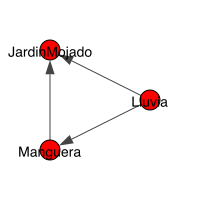

In [9]:
B.ver_red()

Ahora debemos asignar las probabilidades. Lo haremos de manera manual, comenzando con la variable `Lluvia`. Corra la siguiente celda e incluya los valores de acuerdo al ejercicio (observe que esta variable no depende de ninguna otra):

In [7]:
B.asignar_probabilidades_m("Lluvia")

Introduzca las probabilidades ['verdadero', 'falso'] para Lluvia
0.2, 0.8


In [8]:
B.ver_nodo("Lluvia")

----------------------
Lluvia
----------------------
verdadero	falso    	
0.2      	0.8      	
----------------------


**Ejercicio 2:**

Corra las dos celdas siguientes para introducir manualmente las probabilidades de las variables `Manguera` y `JardinMojado`.

In [10]:
B.asignar_probabilidades_m("Manguera")

Introduzca las probabilidades ['verdadero', 'falso'] para Manguera
dado el valor verdadero de Lluvia
.01, .99
Introduzca las probabilidades ['verdadero', 'falso'] para Manguera
dado el valor falso de Lluvia
.4, .6


In [12]:
B.asignar_probabilidades_m("JardinMojado")

Introduzca las probabilidades ['verdadero', 'falso'] para JardinMojado
dados los valores ('verdadero', 'verdadero') de ['Lluvia', 'Manguera']
.99, .01
Introduzca las probabilidades ['verdadero', 'falso'] para JardinMojado
dados los valores ('verdadero', 'falso') de ['Lluvia', 'Manguera']
.9, .1
Introduzca las probabilidades ['verdadero', 'falso'] para JardinMojado
dados los valores ('falso', 'verdadero') de ['Lluvia', 'Manguera']
.8, .2
Introduzca las probabilidades ['verdadero', 'falso'] para JardinMojado
dados los valores ('falso', 'falso') de ['Lluvia', 'Manguera']
0, 1


Corra las siguientes dos celdas para comprobar las tablas de probabilidad respectivas.

In [11]:
B.ver_nodo("Manguera")

---------------------------------------
Manguera
---------------------------------------
Lluvia   	verdadero	falso    	
verdadero	0.01     	0.99     	
falso    	0.4      	0.6      	

---------------------------------------


In [17]:
B.ver_nodo("JardinMojado")

---------------------------------------
JardinMojado
---------------------------------------
Lluvia   	Manguera 	verdadero	falso    	
verdadero	verdadero	0.99     	0.01     	
verdadero	falso    	0.9      	0.1      	
falso    	verdadero	0.8      	0.2      	
falso    	falso    	0.0      	1.0      	

---------------------------------------


---

Para que se familiarice un poco con el atributo `.red`, el cual es un objeto igraph que representa el grafo subyacente, se sugiere realizar el siguiente ejercicio.

**Ejercicio 3:**

Complete la siguiente implementación de la función `clausura_ascendencia`, la cual toma una lista de variables y retorna una lista sin repeticiones que incluye tanto estas variables como todos sus respectivos padres y los padres de sus padres, etc. Por ejemplo, `clausura_ascendencia([JardinMojado])=[Lluvia, Manguera, JardinMojado]`. 

In [27]:
def clausura_ascendencia(self, variables):
    lista = []
    for variable in variables:
        indice = self.red.vs.find(nombre=variable).index
        nodo = self.red.vs[indice]
        padres = nodo['padres']
        if len(padres) == 0:
            pass
        else:
            pass
    return lista + variables

# Se incluye esta función como método de la clase `red_bayesiana`.
setattr(red_bayesiana, "clausura_ascendencia", clausura_ascendencia)

In [28]:
B.clausura_ascendencia(["JardinMojado"])

['Lluvia', 'Manguera', 'JardinMojado']

---

### Implementación de las funciones de probabilidad

En este momento ya tenemos la estructura de la red lista. Ahora la tarea es implementar las funciones de probabilidad. La primera de ellas es la probabilidad de que una variable tome un valor específico, dados los valores de todos sus padres (y de los padres de sus padres, etc.). Para ello, primero implementaremos una función muy útil, cuya tarea será determinar si un diccionario de la forma `{variable:valor}` incluye valores para toda la ascendencia (padres, los padres de los padres, etc.) de una variable dada.

**Ejercicio 4:**

Implemente la función `contiene_ascendencia`, la cual toma una `variable` y un diccionario de la forma `{variable:valor}` y verifica que incluye valores para todos sus padres (y los padres de sus padres, etc.). Observe que no se requiere que el diccionario incluya valores para `variable`.

In [34]:
B.contiene_ascendencia("JardinMojado", {"Manguera":"verdadero"})

False

---

La primera función que implementamos consiste en devolver la probabilidad de que `variable` tome un valor específico, dados los valores de todos sus padres (y de los padres de sus padres, etc.). La implementación es un poco intrincada, debido a los tres tipos posibles de tablas de verdad, basados en si la variable no tiene padres, uno solo, o varios. Se presenta comleta en la siguiente celda.

In [36]:
def P_cond(self, variable, valor, variables_valores):
    if self.contiene_ascendencia(variable, variables_valores):
        indice = self.red.vs.find(nombre=variable).index
        nodo = self.red.vs[indice]
        padres = nodo['padres']
        indice_valor = nodo['valores'].index(valor)
        if len(padres) == 0:
            return nodo['probabilidades'][indice_valor]
        elif len(padres) == 1:
            madre = padres[0]
            valor_madre = variables_valores[madre]
            return nodo['probabilidades'][valor_madre][indice_valor]
        else:
            valor = tuple([variables_valores[v] for v in nodo['padres']])
            return nodo['probabilidades'][valor][indice_valor]
    else:
        print("Faltan valores de variables. Una alternativa que puede usar es el método consulta().")
        raise

setattr(red_bayesiana, "P_cond", P_cond)

In [37]:
B.P_cond("Manguera", "verdadero", {"Lluvia":"falso"})

0.4

La tarea ahora es implementar la función semántica de las redes bayesianas. Recuerde que la estructura de este tipo de reds permite determinar cualquier **probabilidad conjunta** de una serie de variables. Comenzaremos con la suposición de que dicha serie es cerrada bajo ascendencia:

$P(X_1,\ldots,X_n)=\Pi_{i_1}^n P(X_i|Padres(X_i))$, donde $Padres(X_i)\subseteq\{X_1,\ldots,X_n\}$.

**Ejercicio 5:**

Use el método `P_cond` para implementar la función `P_conj`, la cual devuelve **la probabilidad conjunta** de los valores de una serie de variables, la cual viene implementada como un diccionario de la forma `{variable:valor}`. 

In [44]:
B.P_conj({"Lluvia":"verdadero", "Manguera":"falso"})

0.198

---

La tercera función de probabilidad que implementaremos es la de **probabilidad marginal**, la cual devuelve la probabilidad conjunta de una lista de variables, pero en la cual falta información (valores para alguno de los ascendientes de las variables). Estas variables faltantes las simbolizaremos por $Y$, de tal manera que la probabilidad marginal la obtenemos mediante la siguiente fórmula:

$P(X_1,\ldots,X_n)=\sum_Y P(X_1,\ldots,X_n,Y)$

La implementación de esta función también es un poco intrincada, así que presentamos el código completo en la siguiente celda:

In [46]:
def P_marg(self, variables_valores):
    variables = self.red.vs['nombre']
    variables_consulta = list(variables_valores.keys())
    variables_ocultas = self.clausura_ascendencia(variables_consulta)
    variables_ocultas = [v for v in variables_ocultas if v not in variables_consulta]
    indices = [self.red.vs.find(nombre=n).index for n in variables_ocultas]
    valores = [self.red.vs[i]['valores'] for i in indices]
    tuplas = list(itertools.product(*valores))
    suma = 0
    for tupla in tuplas:
        dict_aux = variables_valores.copy()
        for i in range(len(tupla)):
            dict_aux[self.red.vs['nombre'][indices[i]]] = tupla[i]
        p = self.P_conj(dict_aux)
        suma += p
    return suma

setattr(red_bayesiana, "P_marg", P_marg)

In [49]:
B.P_marg({"Manguera":"verdadero"})

0.32200000000000006

### Consultas

Tenemos ya todas las herramientas para calcular cualquier consulta que se nos presente. Las consultas consisten en saber cuál es la probabilidad de que una variable o variables tomen un valor o valores determinados. Consideraremos dos tipos de consultas, aunque ambas irán en la misma función. 

El primero es cuando no hay evidencia disponible. En este caso, la respuesta a la consulta es simplemente la probabilidad **marginal** de que las variables tomen los valores respectivos. 

El segundo tipo es cuando hay evidencia disponible $E$ (que viene dada en forma de un diccionario `{variable:valor}`). Aquí, la respuesta a la consulta es la probabilidad **condicional** de que las variables tomen los valores respectivos dada la evidencia. Para encontrar esta probabilidad con base en las funciones ya definidas mediante la fórmula `P_marg(variables_valores + evidencia)`/`P_marg(evidencia)`.

La evidencia se guardará en el atributo `.evidencia` del objeto `red_bayesiana`.

In [50]:
def incluir_evidencia(self, nombre, valor):
    self.evidencia[nombre] = valor
    
setattr(red_bayesiana, "incluir_evidencia", incluir_evidencia)

In [ ]:
B.incluir_evidencia("JardinMojado", "verdadero")

**Ejercicio 6:**

Implemente la función `consulta` la cual toma una lista de variables con sus respectivos valores y calcula la consulta, teniendo en cuenta si hay evidencia disponible o no.

In [53]:
B.consulta({"Lluvia":"verdadero"})

 La probabilidad de {'Lluvia': 'verdadero'}
 dada la evidencia {'JardinMojado': 'verdadero'}
 es: 0.3576876756322762


0.3576876756322762

**Ejercicio 7:**

Implemente la red bayesiana del ejercicio 2 de las diapositivas y determine la probabilidad de robo dado que John y Mary llaman.

<img src="./imagenes/ejercicio2.png" width="600">

In [56]:
B.incluir_evidencia("JohnCalls", "verdadero")
B.incluir_evidencia("MaryCalls", "verdadero")
B.consulta({"Burglary":"verdadero"})

 La probabilidad de {'Burglary': 'verdadero'}
 dada la evidencia {'JohnCalls': 'verdadero', 'MaryCalls': 'verdadero'}
 es: 0.2841718353643929


0.2841718353643929

---

**Ejercicio 8:**

Implemente la red bayesiana del ejercicio 3 de las diapositivas y determine la probabilidad de haya un pozo en $(0,2)$ dado que hay brisa en $(1,0)$ y en $(0,1)$.

<img src="./imagenes/ejercicio3.png" width="600">